In [ ]:
import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm as tqdm
import pandas as pd

In [ ]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):

    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))

    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    return samples

In [ ]:
def potential_grad(sample, mu, cov):

    precision = jnp.linalg.inv(cov)

    return (sample - mu) @ precision

In [ ]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=100, seed=0):
    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples

    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise

    return evolved_samples

In [ ]:
def compute_moments_disc(samples, evolved_samples):

    mu_1 = jnp.mean(samples, axis=0)
    mu_2 = jnp.mean(evolved_samples, axis=0)

    centered_1 = samples - mu_1
    centered_2 = evolved_samples - mu_2

    cov_1 = centered_1.T @ centered_1 / samples.shape[0]
    cov_2 = centered_2.T @ centered_2 / evolved_samples.shape[0]

    loss_mu = jnp.sum((mu_1 - mu_2) ** 2)
    loss_cov = jnp.sum((cov_1 - cov_2) ** 2)

    return loss_mu + loss_cov

In [ ]:
def lm_loss(samples, mu, cov):

    evolved_samples = evolve_langevin(samples, mu, cov)

    return compute_moments_disc(samples, evolved_samples)

In [ ]:
def lm_optimize(samples, n_epochs=1000, lr=1e-2, seed=10, eps=1e-2, plot_every=2):
    n, d = samples.shape

    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)

    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))

    params = {
        "mu": mu,
        "A": A
    }

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)

    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")

    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]

    return final_mu, final_cov

In [ ]:
def lm_optimize_with_tracking(samples, true_mu, true_cov, n_epochs=1000, lr=1e-2, seed=10, eps=1e-2, plot_every=2):
    n, d = samples.shape

    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)

    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))

    params = {
        "mu": mu,
        "A": A
    }

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)

    history = {
        "loss": [],
        "mu_l2": [],
        "cov_fro": [],
    }

    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        # Tracking
        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val

        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))

        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")

    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]

    return final_mu, final_cov, history

In [ ]:
mu = jnp.array([0.0, 1.0, -1.0])

cov = jnp.array([
    [1.0, 0.5, 0.2],
    [0.5, 1.0, 0.3],
    [0.2, 0.3, 1.0]
])

In [ ]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)

final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=200, lr=0.05, seed = 0)

epoch 0 | loss = 5.841085
epoch 2 | loss = 4.743067
epoch 4 | loss = 4.160919
epoch 6 | loss = 3.801083
epoch 8 | loss = 3.553722
epoch 10 | loss = 3.389393
epoch 12 | loss = 3.211718
epoch 14 | loss = 2.926871
epoch 16 | loss = 2.544439
epoch 18 | loss = 2.118685
epoch 20 | loss = 1.697669
epoch 22 | loss = 1.307083
epoch 24 | loss = 0.957494
epoch 26 | loss = 0.663151
epoch 28 | loss = 0.450399
epoch 30 | loss = 0.337580
epoch 32 | loss = 0.295985
epoch 34 | loss = 0.262369
epoch 36 | loss = 0.212645
epoch 38 | loss = 0.165838
epoch 40 | loss = 0.135126
epoch 42 | loss = 0.115154
epoch 44 | loss = 0.097692
epoch 46 | loss = 0.081424
epoch 48 | loss = 0.068824
epoch 50 | loss = 0.060194
epoch 52 | loss = 0.052635
epoch 54 | loss = 0.043112
epoch 56 | loss = 0.031333
epoch 58 | loss = 0.020060
epoch 60 | loss = 0.012712
epoch 62 | loss = 0.010254
epoch 64 | loss = 0.010418
epoch 66 | loss = 0.010017
epoch 68 | loss = 0.007863
epoch 70 | loss = 0.005295
epoch 72 | loss = 0.004092
epoch 

In [ ]:
jnp.set_printoptions(precision=4, suppress=True)

print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov), "\n\n\n")

[ 0.  1. -1.] 

 [ 0.0054  1.0677 -0.9752] 0.072271675 



[[1.  0.5 0.2]
 [0.5 1.  0.3]
 [0.2 0.3 1. ]] 

 [[1.0553 0.5297 0.1823]
 [0.5297 1.0111 0.3041]
 [0.1823 0.3041 1.0764]] 0.10701406 





In [ ]:
history_np = {k: np.array(v) for k, v in history.items()}

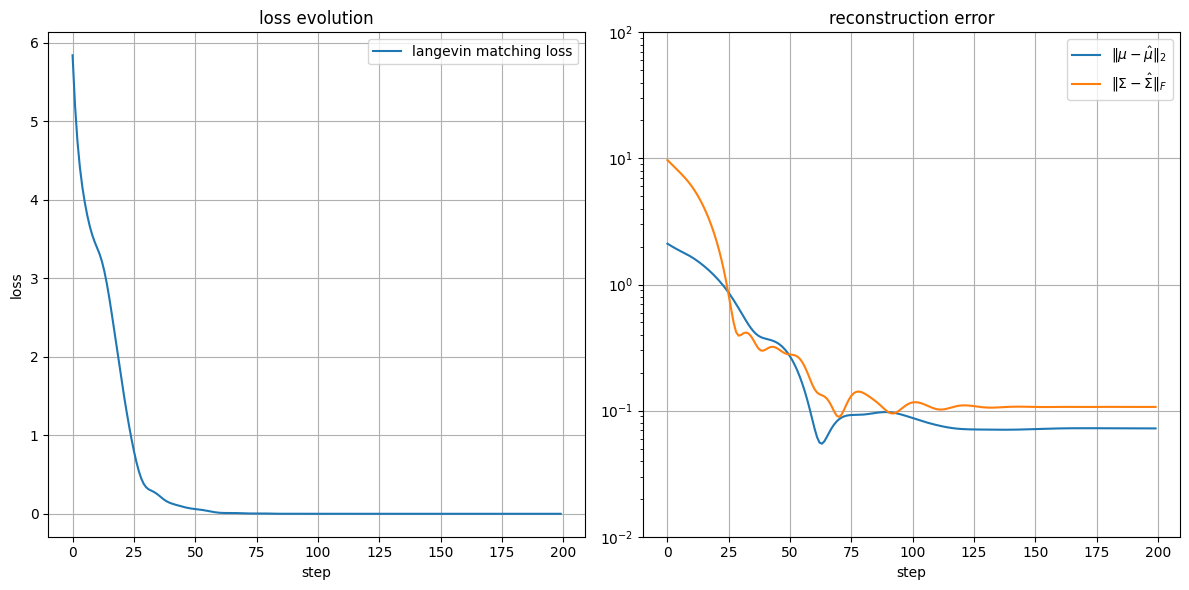

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="langevin matching loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.title("loss evolution")
plt.grid(True)
plt.legend()

ymin_recon = 1e-2
ymax_recon = 100.0
plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"], label=r"$\| \mu - \hat{\mu} \|_2$")
plt.plot(history_np["cov_fro"], label=r"$\| \Sigma - \hat{\Sigma} \|_F$")
plt.ylim(ymin_recon, ymax_recon)
plt.yscale("log")
plt.xlabel("step")
plt.title("reconstruction error")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
history_np["mu_l2"]

array([2.1088, 2.0513, 1.9971, 1.9465, 1.8993, 1.8551, 1.8131, 1.7722,
       1.7312, 1.6887, 1.6441, 1.5975, 1.5491, 1.4993, 1.4484, 1.3967,
       1.3444, 1.2916, 1.2384, 1.1849, 1.131 , 1.0769, 1.0225, 0.9679,
       0.9133, 0.8589, 0.8049, 0.7518, 0.6999, 0.65  , 0.6025, 0.5583,
       0.518 , 0.4824, 0.452 , 0.4272, 0.4078, 0.3935, 0.3834, 0.3765,
       0.3716, 0.3675, 0.3632, 0.3579, 0.3512, 0.3425, 0.3317, 0.3188,
       0.3039, 0.2871, 0.2687, 0.2489, 0.2281, 0.2067, 0.1849, 0.1632,
       0.142 , 0.1217, 0.1028, 0.0859, 0.0719, 0.0615, 0.0558, 0.0547,
       0.0572, 0.0619, 0.0674, 0.0729, 0.0779, 0.0821, 0.0855, 0.0881,
       0.09  , 0.0912, 0.0919, 0.0923, 0.0925, 0.0925, 0.0926, 0.0928,
       0.0931, 0.0935, 0.0941, 0.0947, 0.0954, 0.096 , 0.0966, 0.097 ,
       0.0973, 0.0973, 0.0972, 0.0968, 0.0963, 0.0955, 0.0946, 0.0935,
       0.0924, 0.0911, 0.0898, 0.0885, 0.0872, 0.086 , 0.0847, 0.0835,
       0.0824, 0.0813, 0.0803, 0.0793, 0.0783, 0.0775, 0.0766, 0.0758,
      

In [ ]:
history_np["cov_fro"]

array([9.7058, 9.2854, 8.883 , 8.4986, 8.1288, 7.7692, 7.4156, 7.0637,
       6.7094, 6.3482, 5.9773, 5.5967, 5.2089, 4.8175, 4.4257, 4.0364,
       3.6522, 3.2752, 2.9079, 2.5524, 2.211 , 1.8862, 1.5808, 1.2979,
       1.0418, 0.8179, 0.6336, 0.4982, 0.4195, 0.393 , 0.398 , 0.4108,
       0.4164, 0.4095, 0.3906, 0.3639, 0.3357, 0.3129, 0.3003, 0.2987,
       0.3047, 0.3131, 0.3193, 0.3209, 0.3174, 0.3099, 0.3004, 0.2913,
       0.2844, 0.2804, 0.2786, 0.2773, 0.2744, 0.2681, 0.2573, 0.2419,
       0.2227, 0.2013, 0.1801, 0.1615, 0.1476, 0.1391, 0.1347, 0.1323,
       0.1294, 0.1245, 0.117 , 0.1077, 0.0982, 0.0912, 0.0891, 0.093 ,
       0.1015, 0.1122, 0.1227, 0.1314, 0.1375, 0.1409, 0.1417, 0.1404,
       0.1377, 0.1342, 0.1303, 0.1264, 0.1223, 0.1182, 0.1139, 0.1094,
       0.1049, 0.1008, 0.0974, 0.0954, 0.0949, 0.0961, 0.0986, 0.102 ,
       0.1057, 0.1093, 0.1124, 0.1147, 0.1161, 0.1166, 0.1162, 0.1151,
       0.1135, 0.1115, 0.1093, 0.1072, 0.1052, 0.1036, 0.1025, 0.102 ,
      

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

sample_sizes = jnp.arange(100, 4001, 100)
n_epochs = 800
lr = 0.05

loss_trajectories = []
mean_error_trajectories = []
cov_error_trajectories = []

for n in tqdm(sample_sizes):
    # Genera dati target
    mu_true = jnp.zeros(2)
    cov_true = jnp.array([[1.0, 0.5], [0.5, 1.0]])
    samples = generate_gaussian_samples(mu_true, cov_true, n_samples=n, seed=0)

    # Inizializza parametri
    key = jax.random.PRNGKey(0)
    key_mu, key_A = jax.random.split(key)
    mu = jax.random.normal(key_mu, shape=(2,))
    A = jax.random.normal(key_A, shape=(2, 2))
    params = {"mu": mu, "A": A}

    # Setup ottimizzazione
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    # Logga la traiettoria
    loss_traj = []
    mu_error_traj = []
    cov_error_traj = []

    for epoch in range(n_epochs):
        cov = params["A"].T @ params["A"]
        loss = lm_loss(samples, params["mu"], cov)
        loss_traj.append(loss)

        mu_error_traj.append(jnp.linalg.norm(params["mu"] - mu_true))
        cov_error_traj.append(jnp.linalg.norm(cov - cov_true))

        grads = jax.grad(lambda p: lm_loss(samples, p["mu"], p["A"].T @ p["A"]))(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

    loss_trajectories.append(jnp.stack(loss_traj))
    mean_error_trajectories.append(jnp.stack(mu_error_traj))
    cov_error_trajectories.append(jnp.stack(cov_error_traj))

# Converto in array 2D: shape = (num_sample_sizes, n_epochs)
loss_matrix = jnp.stack(loss_trajectories)
mu_err_matrix = jnp.stack(mean_error_trajectories)
cov_err_matrix = jnp.stack(cov_error_trajectories)

# Plotta le heatmaps 2D
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

im0 = axs[0].imshow(loss_matrix, aspect='auto', origin='lower', extent=[0, n_epochs, 100, 4000])
axs[0].set_title("Loss trajectory")
axs[0].set_ylabel("n_samples")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(mu_err_matrix, aspect='auto', origin='lower', extent=[0, n_epochs, 100, 4000])
axs[1].set_title("Mean reconstruction error")
axs[1].set_ylabel("n_samples")
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(cov_err_matrix, aspect='auto', origin='lower', extent=[0, n_epochs, 100, 4000])
axs[2].set_title("Covariance reconstruction error")
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("n_samples")
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()


 48%|████▊     | 19/40 [2:13:32<1:21:37, 233.21s/it]  